References:
- scikit-learn toy dataset generation: https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.
- Mozannar & Sontag repo: https://github.com/clinicalml/learn-to-defer/blob/master/synthetic/syntheticdata_reject.ipynb
- non-linear classification: https://www.cse.chalmers.se/~richajo/dit866/backup_2019/lectures/l6/Nonlinear%20classification%20toy%20example.html

In [1]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import random

# Create environment

## Data generation

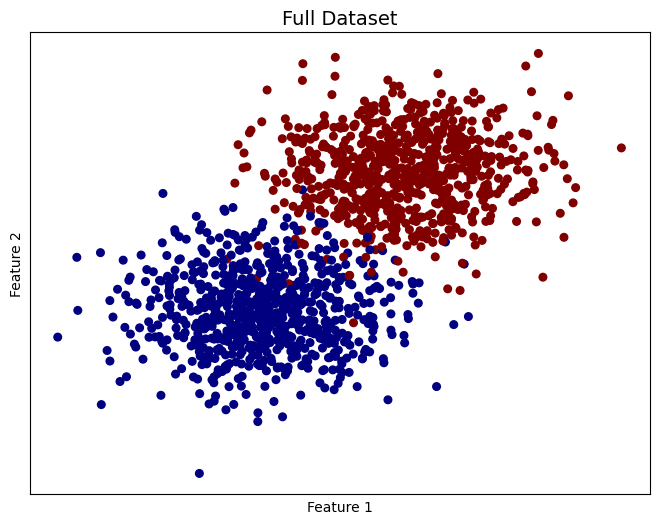

In [466]:
# Varied blobs dataset
n_samples = 1500
varied = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=[2.5, 2.5],random_state=1323)

X, y = varied # y binary 0,1

# Normalize the dataset (from scikit learn website)
X_normalized = StandardScaler().fit_transform(X)

# Agglomerative Clustering object with Average Linkage (from scikit learn website)
n_clusters = 2  # Number of clusters
average_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# Fit data and cluster
cluster_labels = average_clustering.fit_predict(X_normalized)

# Visualize clusters
plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap='jet')

plt.title('Full Dataset', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.show()

- Two clusters generated by two features (random arbitrary values) with binary responses (0,1)
- 0 and 1 evenly distributed (750 counts each)
- Not linearly separatable

# Create human experts

- Refers to each type of human expert  decision heuristic for making predictions
- We have two sets of experts. Let’s use 1 for  majority and 2 for minority

## Expert 1
- x1,x2 > 1 = 1
- x1,x2 < -1 = 0
- x1 >= 1, x2 < 1 = 1

In [432]:
def expert1(inputs):
    #return np.ones(len(inputs))
    #return np.where((inputs[:,0] > 1) & (inputs[:,1] > 1), 1, 0)
    return np.where((inputs[:,0] < -1) & (inputs[:,1] < -1), 0, 1)
    #return np.where((inputs[:,0] >= 1) & (inputs[:,1] < 1), 1, 0)
    #return np.where((inputs[:,0] >= 1) & (inputs[:,1] < 1), 1, 0)

In [433]:
y_expert1 = expert1(X)

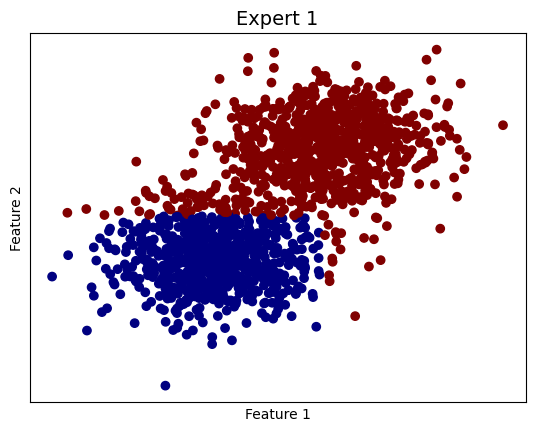

In [434]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X[:,0], X[:,1], c=y_expert1, cmap='jet')
plt.show()

## Expert 2
- x1,x2 < 1 = 1
- x1,x2 > -1 = 0
- x1 <= 1, x2 > 1 = 1

In [429]:
def expert2(inputs):
    #return np.zeros(len(inputs))
    #return np.where((inputs[:,0] < 1) & (inputs[:,1] < 1), 1, 0)
    return np.where((inputs[:,0] > -1) & (inputs[:,1] > -1), 0, 1)
    #return np.where((inputs[:,0] <= 1) & (inputs[:,1] > 1), 1, 0)

In [430]:
y_expert2 = expert2(X)

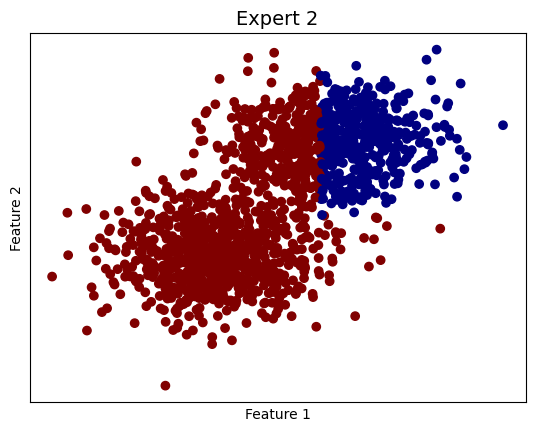

In [431]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X[:,0], X[:,1], c=y_expert2, cmap='jet')
plt.show()

# Generate training dataset

- Experts are treated as exchangeable
- For each data point, we randomly select a type of expert, based on their prevalence
- X: input
- y: output
- y_hat: expert prediction

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, stratify=y, random_state=456)

# Train model and rejector

- From Mozannar & Sontag

- Goal to learn two functions: 1) a classifier that can predict the target and 2) a rejector which decides whether the classifier or expert should predict
- The expert deferral pipeline, the rejector first r(x) decides who between the classifier m and expert h should predict and then whoever makes the final prediction incurs a specific cost

In [456]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+1) # out: 0,1,2
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=1) # dim = 0,1?

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

- "we can see that the loss on examples where the expert makes a mistake becomes the cross entropy loss with the target. On the other hand, when the expert agrees with the target, the learner faces two opposing decisions whether to defer or predict the target"

In [7]:
def reject_CrossEntropyLoss(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs =  -h*torch.log2( outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

- "Querying the expert implies deferring the decision which incurs a cost l_exp(x, y, h)"
- "Without querying the expert implies that a classifier makes the final decision and incurs a cost l(x, y, y_hat)"
- "The classifier and expert costs are the logistic loss between the target and their predictions in the binary target setting"
- "Costs are the misclassifiction error with the target"

In [8]:
def run_classifier_rej(model, data_x, data_y, alpha, p):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*50)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        x_batches = torch.split(inputs,2)
        y_batches = torch.split(labels,2)  
        for inputs, labels in zip(x_batches, y_batches):
            # get the inputs; data is a list of [inputs, labels]

            optimizer.zero_grad()
            #inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to float32 if needed

            # forward + backward + optimize
            rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2

            if rand_exp == 1:
                predicted = torch.tensor(expert1(inputs))
            elif rand_exp == 2:
                predicted = torch.tensor(expert2(inputs))

            h = (predicted==labels)*1
            m = [0] * len(inputs) # classifier
            for j in range (0,len(inputs)):
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2)

            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

    #print('Finished Training')

- "We can encourage or hinder the action of deferral by modifying the loss with an additional parameter alpha"
- Purpose of alpha: "re-weight examples where the expert is correct to discourage the learner of fitting them and instead focus on examples where the expert makes a mistake"

In [457]:
m = Linear_net_rej(2,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, X_train, y_train, alpha, p)

# Test overall system with a sequence of experts

- "We only reject the classifier if it’s expected error is higher than the expected error of the expert"

- "The learned model should adapt to the underlying human expert in order to achieve better performance than deploying the model or expert individually"
- "We will only assume in this work that we are allowed access to samples of the experts decisions or to costs of deferring"

In [317]:
def test_classifier_rej(model, data_x, data_y, p):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    #correct_sys = 0
    exp1 = 0
    exp1_total = 0
    exp2 = 0
    exp2_total = 0
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs =  torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #1 (ML), 2 (defer to expert)
        
        for i in range(len(inputs)):
            rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2 for each point
            if rand_exp == 1:
                predicted_exp = torch.tensor(expert1(inputs))
            elif rand_exp == 2:
                predicted_exp = torch.tensor(expert2(inputs))
                
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                #correct_sys += (predicted_exp[i] == labels[i]).item()
                if rand_exp == 1:
                    exp1 += (predicted_exp[i] == labels[i]).item()
                    exp1_total += 1
                elif rand_exp == 2:
                    exp2 += (predicted_exp[i] == labels[i]).item()
                    exp2_total += 1
            else:
                correct += (predicted[i] == labels[i]).item() 
                #correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)
    #cov = str(total) + str(" out of") + str(real_total)

    #print("coverage", cov)
    #print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()
    print("expert 1 defer count:", exp1_total) # how many times deferred to expert 1
    print("expert 1 defer percent:", 100*exp1_total/points) # percentage of times deferred to expert 1
    print("expert 1 correct predictions:", exp1) # how many times expert 1 was correct
    print("expert 1 accuracy:",100* exp1/(exp1_total+0.0002)) # correct predictions of expert 1 when deferred
    print()
    print("expert 2 defer count:", exp2_total) # how many times deferred to expert 2
    print("expert 2 defer percent:", 100*exp2_total/points) # percentage of times deferred to expert 2
    print("expert 2 correct predictions:", exp2) # how many times expert 2 was correct
    print("expert 2 accuracy:",100* exp2/(exp2_total+0.0002)) # correct predictions of expert 2 when deferred
    print()
    print("not deferred to expert count:", total) # how many times did not defer
    print("not deferred percent:", 100*total/points) # percentage of times not deferred to any expert
    print("model correct predictions:", correct) # how many times model was correct
    print("model accuracy:", 100 * correct / (total + 0.0001)) # correct predictions of model alone
    print()
    print("expert 1 to expert 2 ratio", exp1_total/exp2_total)
    

    #return [100*total/real_total,  100*correct_sys/real_total, 100* exp/(exp_total+0.0002),100*correct/(total+0.0001) ]

In [458]:
test_classifier_rej(m, X_test, y_test, p)

total points: 450

expert 1 defer count: 80
expert 1 defer percent: 17.77777777777778
expert 1 correct predictions: 67
expert 1 accuracy: 83.74979062552343

expert 2 defer count: 87
expert 2 defer percent: 19.333333333333332
expert 2 correct predictions: 18
expert 2 accuracy: 20.689607610097447

not deferred to expert count: 283
not deferred percent: 62.888888888888886
model correct predictions: 281
model accuracy: 99.29325113312682

expert 1 to expert 2 ratio 0.9195402298850575


# Human experts as non-linear classifiers

In [321]:
from sklearn.tree import DecisionTreeClassifier

In [448]:
def plot_boundary(clf, X, Y):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap='jet', edgecolors='k')

### Expert 1

In [467]:
X_train_exp1 = X[222::3]
y_train_exp1 = y[222::3]

In [468]:
exp_1 = DecisionTreeClassifier().fit(X_train_exp1, y_train_exp1)

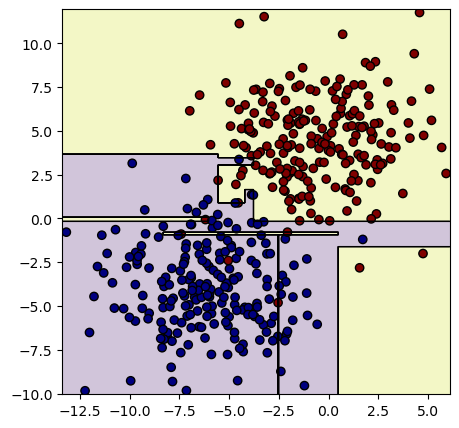

In [469]:
plot_boundary(exp_1, X_train_exp1, y_train_exp1)

### Expert 2

In [470]:
X_train_exp2 = X[444::2]
y_train_exp2 = y[444::2]

In [471]:
exp_2 = DecisionTreeClassifier().fit(X_train_exp2, y_train_exp2)

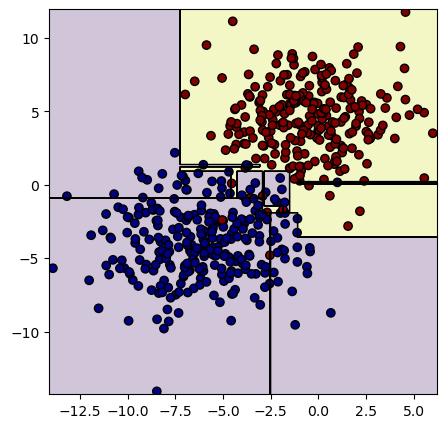

In [472]:
plot_boundary(exp_2, X_train_exp2, y_train_exp2)

## Train model and rejector

In [327]:
def run_classifier_rej2(model, data_x, data_y, alpha, p):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*50)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        x_batches = torch.split(inputs,2)
        y_batches = torch.split(labels,2)  
        for inputs, labels in zip(x_batches, y_batches):
            # get the inputs; data is a list of [inputs, labels]

            optimizer.zero_grad()
            #inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to float32 if needed

            # forward + backward + optimize
            rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2

            if rand_exp == 1:
                predicted = torch.tensor(exp_1.predict(inputs))
            elif rand_exp == 2:
                predicted = torch.tensor(exp_2.predict(inputs))

            h = (predicted==labels)*1
            m = [0] * len(inputs) # classifier
            for j in range (0,len(inputs)):
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2)

            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

    #print('Finished Training')

In [473]:
m = Linear_net_rej(2,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej2(m, X_train, y_train, alpha, p)

## Test with experts as non-linear classifiers

In [329]:
def test_classifier_rej2(model, data_x, data_y, p):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    #correct_sys = 0
    exp1 = 0
    exp1_total = 0
    exp2 = 0
    exp2_total = 0
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs =  torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #1 (ML), 2 (defer to expert)
        
        for i in range(len(inputs)):
            rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2 for each point
            if rand_exp == 1:
                predicted_exp = torch.tensor(exp_1.predict(inputs))
            elif rand_exp == 2:
                predicted_exp = torch.tensor(exp_2.predict(inputs))
                
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                #correct_sys += (predicted_exp[i] == labels[i]).item()
                if rand_exp == 1:
                    exp1 += (predicted_exp[i] == labels[i]).item()
                    exp1_total += 1
                elif rand_exp == 2:
                    exp2 += (predicted_exp[i] == labels[i]).item()
                    exp2_total += 1
            else:
                correct += (predicted[i] == labels[i]).item() 
                #correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)
    #cov = str(total) + str(" out of") + str(real_total)

    #print("coverage", cov)
    #print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()
    print("expert 1 defer count:", exp1_total) # how many times deferred to expert 1
    print("expert 1 defer percent:", 100*exp1_total/points) # percentage of times deferred to expert 1
    print("expert 1 correct predictions:", exp1) # how many times expert 1 was correct
    print("expert 1 accuracy:",100* exp1/(exp1_total+0.0002)) # correct predictions of expert 1 when deferred
    print()
    print("expert 2 defer count:", exp2_total) # how many times deferred to expert 2
    print("expert 2 defer percent:", 100*exp2_total/points) # percentage of times deferred to expert 2
    print("expert 2 correct predictions:", exp2) # how many times expert 2 was correct
    print("expert 2 accuracy:",100* exp2/(exp2_total+0.0002)) # correct predictions of expert 2 when deferred
    print()
    print("not deferred to expert count:", total) # how many times did not defer
    print("not deferred percent:", 100*total/points) # percentage of times not deferred to any expert
    print("model correct predictions:", correct) # how many times model was correct
    print("model accuracy:", 100 * correct / (total + 0.0001)) # correct predictions of model alone
    print()
    print("expert 1 to expert 2 ratio", exp1_total/exp2_total)
    

    #return [100*total/real_total,  100*correct_sys/real_total, 100* exp/(exp_total+0.0002),100*correct/(total+0.0001) ]

In [481]:
test_classifier_rej2(m, X_test, y_test, p)

total points: 450

expert 1 defer count: 157
expert 1 defer percent: 34.888888888888886
expert 1 correct predictions: 141
expert 1 accuracy: 89.80880279133402

expert 2 defer count: 184
expert 2 defer percent: 40.888888888888886
expert 2 correct predictions: 122
expert 2 accuracy: 66.304275756222

not deferred to expert count: 109
not deferred percent: 24.22222222222222
model correct predictions: 109
model accuracy: 99.9999082569649

expert 1 to expert 2 ratio 0.8532608695652174


With experts as nonlinear classifiers, experts are deferred to more

TODO:
- refine code to make it more general with more than two experts?
- create own data normally distributed